In [1]:
%reload_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv
%matplotlib inline

In [2]:
from xcube_sh.config import CubeConfig
from xcube_sh.cube import open_cube
from xcube_sh.sentinelhub import SentinelHub
import xarray as xr
import numpy as np
import os
import json
import shapely.geometry
import IPython.display
from src.GIS_utils import bbox_from_point

In [3]:
SH = SentinelHub()
print(SH.dataset_names)

None


In [4]:
SH.band_names('S1GRD')

['VV', 'VH', 'HH', 'HV']

In [5]:
data_dir = "/home/jovyan/data" # data directory (path)
RADIUS = 500 # AOI radius in meters

spatial_res = 0.00018
start_date = '2019-03-01'
end_date = '2019-06-01'

with open(os.path.join(data_dir, 'aoi.json'), 'r') as f:
    aoi_file = json.load(f)
    coord = aoi_file['Straits']['Bosporus'][5]
    lat, lon = coord[0], coord[1]
    print('{}, {}'.format(lat, lon))

40.994, 29.017


In [6]:
bbox = bbox_from_point(lat=lat, lon=lon, r=RADIUS) # WGS84 coordinates

In [7]:
bbox = bbox_from_point(lat=lat, lon=lon, r=RADIUS) # WGS84 coordinates
IPython.display.GeoJSON(shapely.geometry.box(*bbox).__geo_interface__)

<IPython.display.GeoJSON object>

In [50]:
cube_config = CubeConfig(dataset_name='S1GRD',
                         band_names=[ 'HH+HV', 'VV+VH', 'HH', 'VV', 'VH'], ## HH,'HV' , 'HH+HV' gives NaN/Zero Exception HH+HV, VV+VH, HH, VV
                         crs = "http://www.opengis.net/def/crs/EPSG/0/4326",
                         spatial_res = 0.00018,
                         geometry=bbox,
                         time_range=[start_date, end_date],
                         time_period='1D')

In [51]:
cube = open_cube(cube_config)
cube

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 50, lon: 66, time: 93)
Coordinates:
  * lat        (lat) float64 41.0 41.0 41.0 41.0 ... 40.99 40.99 40.99 40.99
  * lon        (lon) float64 29.01 29.01 29.01 29.01 ... 29.02 29.02 29.02 29.02
  * time       (time) datetime64[ns] 2019-03-01T12:00:00 ... 2019-06-01T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(93, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    HH         (time, lat, lon) float32 dask.array<chunksize=(1, 50, 66), meta=np.ndarray>
    HH+HV      (time, lat, lon) float32 dask.array<chunksize=(1, 50, 66), meta=np.ndarray>
    VH         (time, lat, lon) float32 dask.array<chunksize=(1, 50, 66), meta=np.ndarray>
    VV         (time, lat, lon) float32 dask.array<chunksize=(1, 50, 66), meta=np.ndarray>
    VV+VH      (time, lat, lon) float32 dask.array<chunksize=(1, 50, 66), meta=np.ndarray>
Attributes:
    Conventions:               CF-1.7
    title:                     S1GRD Data Cube Subset
    history:                   [{'program': 'xcube_sh.store.SentinelHubStore'...
    date_created:              2020-06-04T09:17:19.188095
    processing_level:          L1B
    time_coverage_start:       2019-03-01T00:00:00+00:00
    time_coverage_end:         2019-06-02T00:00:00+00:00
    time_coverage_duration:    P93DT0H0M0S
    time_coverage_resolution:  P1DT0H0M0S
    geospatial_lon_min:        29.011059019742685
    geospatial_lat_min:        40.98949867050243
    geospatial_lon_max:        29.022939019742687
    geospatial_lat_max:        40.99849867050243

In [52]:
nans_how = 'any'
# cube = cube.dropna(dim='time',how=nans_how) # drop images w/ any nan. This line will crash since not all bands are presence 
cube = cube.where(cube.VV.mean(dim=('lat','lon')) > 0.0, drop=True) 

In [53]:
cube.VH.isel(time=3).values

array([[0.0052, 0.0021, 0.0042, ..., 0.0228, 0.0163, 0.0135],
       [0.0071, 0.004 , 0.0037, ..., 0.0127, 0.0215, 0.0182],
       [0.0042, 0.0047, 0.0042, ..., 0.0203, 0.0237, 0.0235],
       ...,
       [0.002 , 0.0012, 0.003 , ..., 0.2827, 0.228 , 0.1503],
       [0.0032, 0.0021, 0.0023, ..., 0.0992, 0.0793, 0.0532],
       [0.0027, 0.001 , 0.0006, ..., 0.1585, 0.1151, 0.1155]],
      dtype=float32)

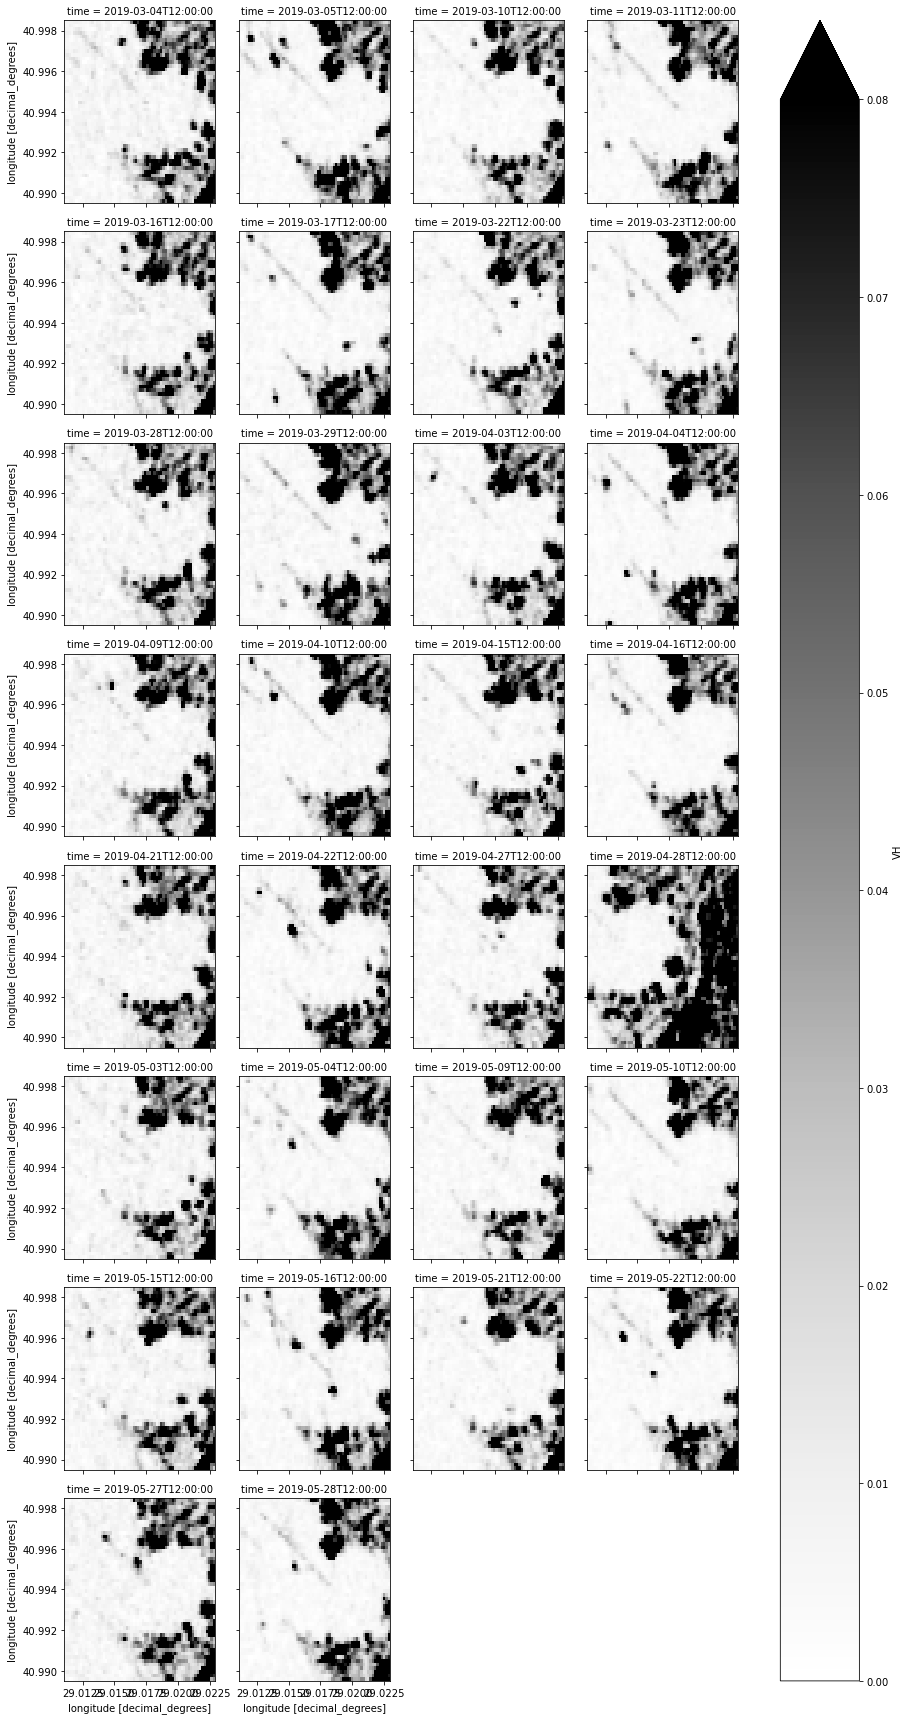

In [55]:
cube.VH.plot.imshow(col='time', col_wrap=4, cmap='Greys',vmax = 0.08)

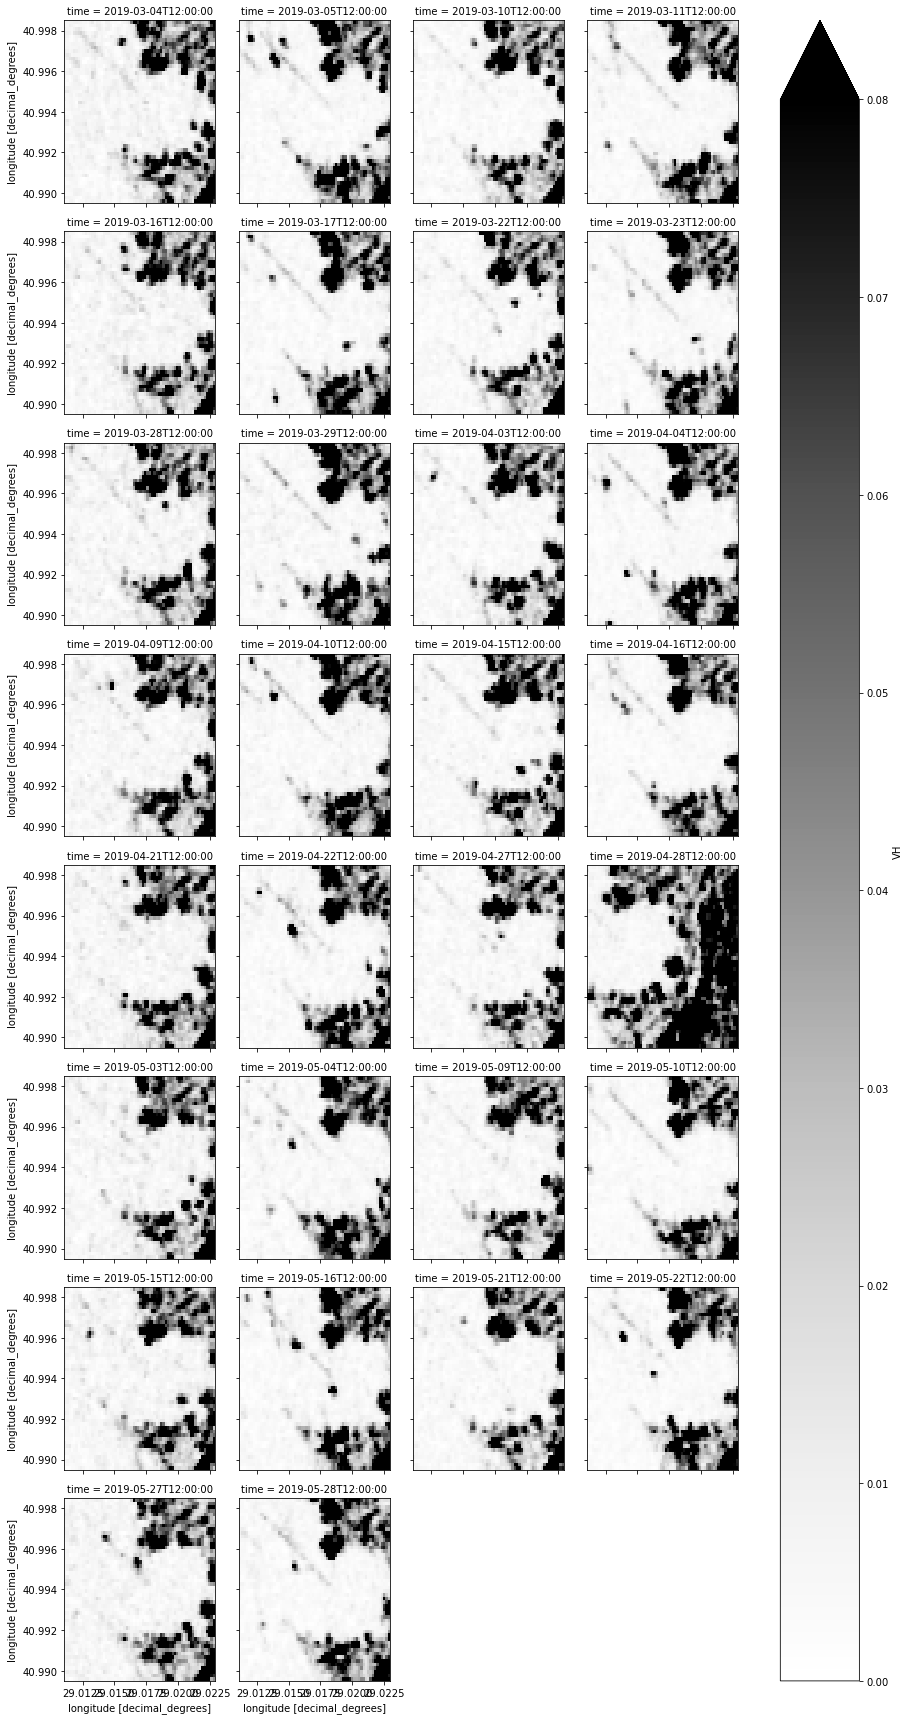

In [56]:
cube.VH.plot.imshow(col='time', col_wrap=4, cmap='Greys',vmax =0.08)